In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Data

Required format:
- Pcode: SKU code
- Price: Unit price of SKU
- Week: Which week it is 
- Quantity Sold: Quantity of SKU sold on the current week

In [9]:
forecasted_info = pd.read_csv("ForecastedInformation.csv")

## Differential Evolution

In [10]:
# One random number generator for algo
rng = np.random.default_rng(seed=207)

In [11]:
def initialize_population(bounds, population_size):
    bounds = np.array(bounds, dtype=np.float64)  # Convert bounds to a NumPy array
    lower_bounds = bounds[:, 0]
    upper_bounds = bounds[:, 1]
    population = rng.uniform(lower_bounds, upper_bounds, (population_size, len(bounds)))
    return population

In [12]:
def differential_evolution(
    objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover,
    quantities, prices, policy_optimization_period, num_skus, a, b, c
):
    # Initialize population and current fitnesses
    population = initialize_population(parameter_bounds, population_size)
    fitness = np.array([
        objective_function(ind, quantities, prices, policy_optimization_period, num_skus, a, b, c)
        for ind in population
    ])

    bounds_array = np.array(parameter_bounds)
    lower_bounds, upper_bounds = bounds_array[:, 0], bounds_array[:, 1]

    for _ in range(n_generations):
        # Mutation and crossover in a vectorized manner
        indices = np.arange(population_size)
        a_indices = rng.choice(indices, size=population_size, replace=True)
        b_indices = rng.choice(indices, size=population_size, replace=True)
        c_indices = rng.choice(indices, size=population_size, replace=True)

        # Ensure indices are not equal to the current individual
        valid = a_indices != indices
        a_indices[~valid] = (a_indices[~valid] + 1) % population_size

        # Calculate mutants
        a1, b1, c1 = population[a_indices], population[b_indices], population[c_indices]
        mutants = a1 + mutation_factor * (b1 - c1)
        mutants = np.clip(mutants, lower_bounds, upper_bounds)

        # Ensure reorder amounts and frequencies are integers
        mutants = np.round(mutants)

        # Perform crossover
        crossover_mask = rng.random((population_size, len(parameter_bounds))) < p_crossover
        trial_population = np.where(crossover_mask, mutants, population)
        # Evaluate the new population
        trial_fitness = np.array([
            objective_function(ind, quantities, prices, policy_optimization_period, num_skus, a, b, c)
            for ind in trial_population
        ])

        # Update population and fitness using a loop
        for i in range(population_size):
            if trial_fitness[i] < fitness[i]:
                population[i] = trial_population[i]
                fitness[i] = trial_fitness[i]

    best_index = np.argmin(fitness)  # Minimize the objective
    return population[best_index], fitness[best_index]


In [13]:
def f(individual, quantities, prices, policy_optimization_period, num_skus, a, b, c):
    # Extract reorder quantities and frequencies from the individual
    reorder_quantities = np.array(individual[0::2], dtype=int)
    reorder_frequencies = np.array(individual[1::2], dtype=int)

    # Initialize SKU quantities and costs
    sku_quantities = np.zeros((policy_optimization_period, num_skus), dtype=np.float64)
    missed_sales = np.zeros(num_skus, dtype=np.float64)
    inventory = np.zeros(policy_optimization_period, dtype=np.float64)
    reorder_cost = np.zeros(num_skus, dtype=np.float64)

    # Create a matrix of time steps
    time_steps = np.arange(1, policy_optimization_period + 1).reshape(-1, 1)

    # If any frequency becomes negative, don't ever restock
    # Otherwise calculate when each restock happens
    adjusted_frequencies = np.where(reorder_frequencies > 0, reorder_frequencies, np.inf)
    restock_mask = (time_steps % adjusted_frequencies) == 0
    restock_mask = np.where(adjusted_frequencies == np.inf, False, restock_mask)

    # Calculate reorder amounts
    reorder_amounts = restock_mask * reorder_quantities
    sku_quantities += np.cumsum(reorder_amounts, axis=0)

    # Subtract demand week by week
    demand_matrix = quantities.T
    sku_quantities -= demand_matrix

    # Calculate missed sales where stock is negative
    missed_stock = np.minimum(sku_quantities, 0)
    missed_sales += np.sum(-missed_stock * prices, axis=0)
    sku_quantities = np.maximum(sku_quantities, 0)

    # Calculate reorder costs
    reorder_cost += np.sum(restock_mask, axis=0)
    # Calculate inventory cost as total stock across all weeks
    inventory += np.sum(sku_quantities, axis=1)

    # Readjust weights and calculate the total cost
    total_cost = (a * np.sum(missed_sales, dtype=np.float64)) + (b * np.sum(inventory, dtype=np.float64)) + (c  * np.sum(reorder_cost, dtype=np.float64))
    return total_cost

## Hyperparameter Search Logic

### User Inputs: ONLY change things here!

In [14]:
# Policy optimization period period- how far in advance we want to forecast the skus
policy_optimization_period = 5
# Weights for missed sales, inventory space, and reorder cost
missed_sales_importance = 1
inventory_space_importance = 1
reorder_cost_importance = 1
# User will input this- it's equivalent to giving a time budget for the algorithm
n_generations = 10000

### Calculation of all relevant differential evolution inputs from the user inputs

In [15]:
### Parameter bound information

# Num skus based on the forecasted_info dataset
num_skus = len(forecasted_info["Pcode"].unique())
# Max order frequency is up to the length of the policy_optimization_period
max_order_frequency = policy_optimization_period
# Upper and lower bounds for both frequency and reorder quantity
parameter_bounds = np.zeros((2*num_skus, 2))
# Get unique SKUs the indices that they map back to
unique_skus, inverse_indices = np.unique(forecasted_info["Pcode"], return_inverse=True)
# Create an array for max quantities for each SKU
max_quantities = np.zeros(len(unique_skus))
np.maximum.at(max_quantities, inverse_indices, forecasted_info["Quantity Sold"].to_numpy())
# Set the upper bounds
parameter_bounds[0::2, 1] = max_quantities  # Max quantity sold
parameter_bounds[1::2, 1] = max_order_frequency  # Max order frequency


### Objective function information

# Calculate the forecast weeks based on the policy optimization period
weeks = np.sort(forecasted_info["Week"].unique())
forecast_weeks = weeks[-policy_optimization_period:]

# Should convert it into the following form:
skus = forecasted_info["Pcode"].unique()

# Get only the forecast weeks
forecast_data = forecasted_info[forecasted_info["Week"].isin(forecast_weeks)]
# Calculate prices
prices = forecasted_info.drop_duplicates(subset="Pcode", keep="first").set_index("Pcode")["Price"].map(lambda x: float(x[1:]))
prices = prices.ravel()
# Calculate quantities (null values are 0 if exist)
quantities_df = forecast_data.pivot(index="Pcode", columns="Week", values="Quantity Sold")
quantities = quantities_df.reindex(skus).fillna(0).to_numpy()

/var/folders/hh/rn_fsj015zz6cmlmssx4w0y00000gn/T/ipykernel_52262/788442118.py:32: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  prices = prices.ravel()


Use optuna for hyperparameter search

In [16]:
import optuna

# Define the objective function for Optuna
def hyperparamter_search_objective(trial):
    population_size = trial.suggest_int('population_size', 10, 50)
    mutation_factor = trial.suggest_float('mutation_factor', 0.1, 2.0)
    p_crossover = trial.suggest_float('p_crossover', 0.1, 0.9)
    
    # Call your differential evolution function with the suggested hyperparameters
    _, score = differential_evolution(
        objective_function=f,
        parameter_bounds=parameter_bounds,
        population_size=int(population_size),
        n_generations=200,
        mutation_factor=mutation_factor,
        p_crossover=p_crossover,
        quantities=quantities,
        prices=prices,
        policy_optimization_period=policy_optimization_period,
        num_skus=num_skus,
        a=missed_sales_importance,
        b=inventory_space_importance,
        c=reorder_cost_importance
    )
    return score  # The goal is to minimize this score

# Create an Optuna study
study = optuna.create_study(direction='minimize') 

# Optimize the objective function
n_trials = 100
study.optimize(hyperparamter_search_objective, n_trials=n_trials) 

# Extract best hyperparameters and score
best_hyperparameters = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_hyperparameters)
print("Best Score:", best_score)

[I 2024-12-01 17:44:35,254] A new study created in memory with name: no-name-9fbb3280-dc2b-4f90-9a5d-249bd4130ae7
[I 2024-12-01 17:44:35,985] Trial 0 finished with value: 10500929.329030972 and parameters: {'population_size': 31, 'mutation_factor': 0.7412609405536915, 'p_crossover': 0.2839639223297396}. Best is trial 0 with value: 10500929.329030972.
[I 2024-12-01 17:44:36,328] Trial 1 finished with value: 8708460.248052293 and parameters: {'population_size': 16, 'mutation_factor': 0.5505322691306598, 'p_crossover': 0.7447270306922562}. Best is trial 1 with value: 8708460.248052293.
[I 2024-12-01 17:44:37,248] Trial 2 finished with value: 16860030.89689436 and parameters: {'population_size': 37, 'mutation_factor': 1.83229588416793, 'p_crossover': 0.7987061855703864}. Best is trial 1 with value: 8708460.248052293.
[I 2024-12-01 17:44:38,110] Trial 3 finished with value: 16966137.616594635 and parameters: {'population_size': 36, 'mutation_factor': 1.1962001142723828, 'p_crossover': 0.400

Best Hyperparameters: {'population_size': 44, 'mutation_factor': 0.10292627296472082, 'p_crossover': 0.30812831637532967}
Best Score: 4867376.8480548635


## Calculate parameters based on the hyperparameter search

In [17]:
# Based on hyperparameter search
population_size = best_hyperparameters["population_size"]
mutation_factor = best_hyperparameters["mutation_factor"]
p_crossover = best_hyperparameters["p_crossover"]

In [18]:
best_parameters, score = differential_evolution(
    f, 
    parameter_bounds, 
    population_size, 
    n_generations, 
    mutation_factor,
    p_crossover, 
    quantities, 
    prices, 
    policy_optimization_period, 
    num_skus, 
    missed_sales_importance, 
    inventory_space_importance, 
    reorder_cost_importance
)

In [19]:
best_parameters

array([1.29e+02, 1.00e+00, 4.29e+02, ..., 1.00e+00, 1.14e+03, 2.00e+00])

## Verification of Output

0
1
2
3
4
5
6
7
8
9


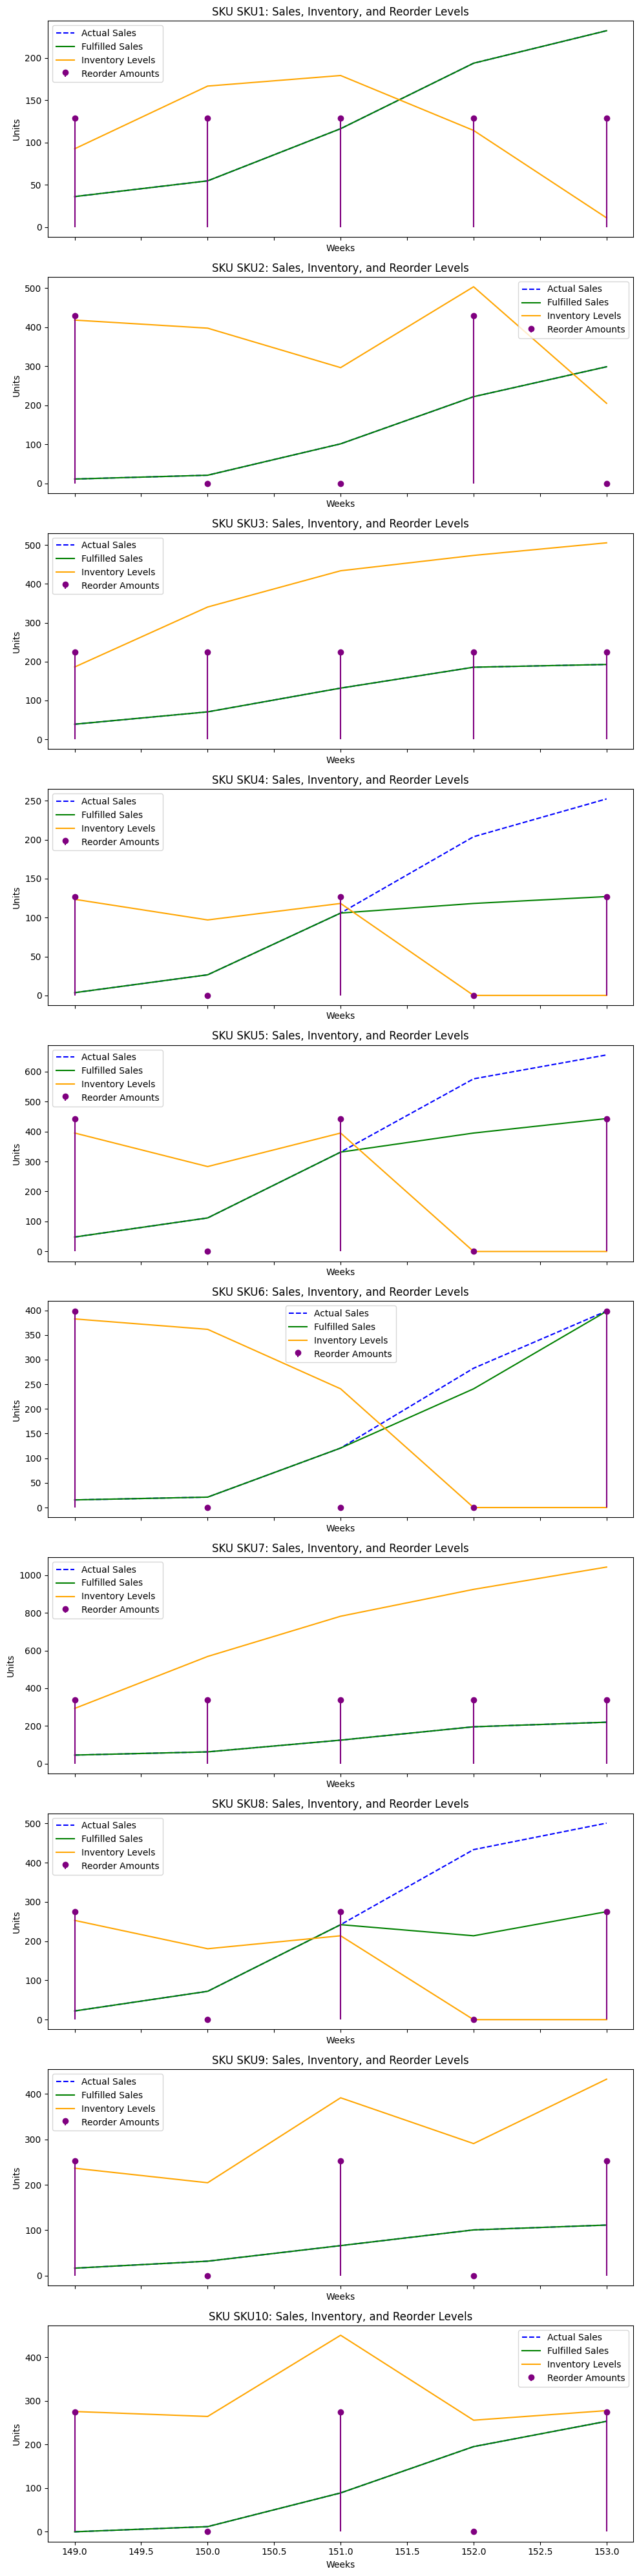

In [21]:
# Corrected simulation of fulfilled sales and inventory
reorder_quantities = np.array(best_parameters[0::2], dtype=int)
reorder_frequencies = np.array(best_parameters[1::2], dtype=int)

fulfilled_sales = np.zeros_like(quantities)
inventory_levels = np.zeros((num_skus, policy_optimization_period))

for sku in range(num_skus):
    inventory = 0  # Initial inventory
    for week in range(policy_optimization_period):
        # Reorder only if reorder frequency > 0 and it's a reorder week
        if reorder_frequencies[sku] > 0 and week % reorder_frequencies[sku] == 0:
            inventory += reorder_quantities[sku]

        # Fulfill sales based on inventory and demand
        fulfilled_sales[sku, week] = min(inventory, quantities[sku, week])
        inventory -= fulfilled_sales[sku, week]

        # Track inventory levels
        inventory_levels[sku, week] = inventory

# Correct reorder tracking
reorder_weeks = np.zeros((num_skus, policy_optimization_period))
for sku in range(num_skus):
    if reorder_frequencies[sku] > 0:
        reorder_weeks[sku, ::reorder_frequencies[sku]] = reorder_quantities[sku]

# Plotting
showing_skus = 10
fig, axes = plt.subplots(showing_skus, 1, figsize=(10, 4 * showing_skus), sharex=True)

for sku, ax in enumerate(axes):
    print(sku)
    ax.plot(forecast_weeks, quantities[sku], label="Actual Sales", color="blue", linestyle="--")
    ax.plot(forecast_weeks, fulfilled_sales[sku], label="Fulfilled Sales", color="green")
    ax.plot(forecast_weeks, inventory_levels[sku], label="Inventory Levels", color="orange")
    ax.stem(forecast_weeks, reorder_weeks[sku], label="Reorder Amounts", linefmt="purple", markerfmt="o", basefmt=" ")
    ax.set_title(f"SKU {skus[sku]}: Sales, Inventory, and Reorder Levels")
    ax.set_xlabel("Weeks")
    ax.set_ylabel("Units")
    ax.legend()

plt.tight_layout()
plt.show()